NOTAS:
he exact 112 stock_ids in the training set will appear in both the public leader board and the private leader board test sets
public test set is hidden and private test set will be real market data collected in the three-month evaluation period after competition ends.

loss: RMSELoss vs MSE?  
https://www.kaggle.com/gunesevitan/optiver-realized-volatility-prediction-eda  
RMSPE is very similar to RMSE. The only difference between them is, the error is divided by the actual value. Predictions closer to actual values yield errors closer to 0, so division by actual values is sensitive to larger errors. In addition to that, errors are squared before they are averaged, which makes this metric even more sensitive to larger errors. This means larger errors are not tolerable in this domain.  
One pitfall of RMSPE is it can raise ZeroDivisionError if a single data point in actual values is equal to 0. Even though, there isn't any 0 target values in training set, this can be easily solved by adding a small constant to actual values. A small constant epsilon wouldn't contribute to overall rmspe and it prevents ZeroDivisionError.

###################################################################################

sumar y mean en las visualizaciones

--- feature engineering (domingo) ---
algo estadístico, Z scores, statistica learning, time series en youtube
necesito calcular el resigo de liquidity drought en base a los volumenes y el spread de alguna forma (order imbalance) - conv 2d  
volumne unbanace, ...
primera derivada, ...

--- model CNN / MLP (lunes y martes) ---
fit on vol delta
arquitectura en general / segundo modelo MLP en secuencia?
exponential avg pooling
2d conv?, wavelet?
auoregressive conv network? inductive kernels?
loss weights
segmentation + transformer?
(NO) nn.GRU nn.RNN nn.LSTM?

--- augmentation y generalization (miercoles y jueves) ---
!!! tengo que incrementar la capacidad del modelo antes de probar generalization: dropout, data augmentation, noise
entrenar con baskets de stocks - esta seria una forma de gerneralizar??
https://docs.scipy.org/doc/scipy/reference/reference/ndimage.html#module-scipy.ndimage
filtros, autoencoder

--- visualizar (viernes) ---
analizar peores predicciones
analizar casos donde no había volatilidad en los primeros 10 minutos, pero la hay en los 10 posteriores

--- competition (fin de semana) ---
releer los FAQS, etc para no dejarme ningún detalle / kaggle notebooks
quitar asserts
cross-validation
reproductibilidad
optim?

In [157]:
import pandas as pd
import numpy as np

from scipy.stats import beta
from sklearn.preprocessing import StandardScaler

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import seaborn as sns

from data import OptiverDataModule
from utils import interp, integ

import skimage.measure

import torch
import torch.nn as nn
import torch.nn.functional as F

pd.set_option('display.max_rows', 500)
np.set_printoptions(threshold=1000, linewidth=150, precision=3, edgeitems=20, suppress=1)

%matplotlib inline

np.set_printoptions(threshold=2000, linewidth=140, precision=4, edgeitems=10, suppress=1)
pd.set_option('display.max_rows', 50)

np.random.seed(0)

from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.signal import argrelmax

In [2]:
data = OptiverDataModule(scale=True, kernel_size=6, stride=6, mks=30)

reading tensors file...


  0%|          | 0/2 [00:00<?, ?it/s]

computing stock stats...
processing series...


100%|██████████| 2/2 [00:06<00:00,  3.16s/it]


min: [-0.00327, -0.00086, 0.0, 0.0, 0.0, 3e-05, 5e-05, 0.0, 0.0, 6e-05, -0.01454, -0.01372, 0.0, 0.0, -0.01178, -0.01346, -0.01229, 0.0, 0.0, -0.00901, -0.02973, -0.02076, 0.0, 0.0, -0.01309, -0.00345, -0.00071, 0.0, 0.0, -5e-05, -0.03077, -0.02133, 0.0, 0.0, -0.01341, 0.0, 0.0, 0.0, 0.0, 0.0]
max: [0.00337, 0.00131, 0.00706, 0.04599, 0.02431, 0.03418, 0.0321, 0.01192, 0.03191, 0.03428, 0.01474, 0.01036, 0.00764, 0.02636, 0.0179, 0.01299, 0.00941, 0.0077, 0.02297, 0.01348, 0.01817, 0.01376, 0.0112, 0.03675, 0.02124, 0.00276, 0.00088, 0.00446, 0.02878, 0.01607, 0.01622, 0.01728, 0.0119, 0.03277, 0.02124, 0.04106, 0.03392, 0.01436, 0.03995, 0.04796]
computing targets...
computing series stats...
abs corrs sorted:
[0.28 0.06 0.  ]
final shape (100000, 3)
coeffs of selected stats:
[-0.06 -0.   -0.28]


In [ ]:
            # print()
            # print('Volatility decreases in general:')
            # print('first 100 seconds:', round(torch.mean(torch.std(log_returns[:,:100], dim=1)*1e3).item(),3))
            # print('last 100 seconds:', round(torch.mean(torch.std(log_returns[:,-100:], dim=1)*1e3).item(),3))
            # print('drop in the last 30 seconds:', round(torch.mean(torch.std(log_returns[:,-30:], dim=1)*1e3).item(),3))

In [3]:
series = data.series
stats = data.stats

targets = pd.DataFrame( data.targets[data.targets[:,-1].argsort()],
                        columns=['stock','window','series','fut_vol','past_vol','vol_delta','vol_increase',])
targets.stock = targets.stock.astype(int)
targets.window = targets.window.astype(int)
targets.series = targets.series.astype(int)
targets

,stock,window,series,fut_vol,past_vol,vol_delta,vol_increase
0,105,487,30693,0.004366,0.035286,-0.030920,-0.876261
1,115,31170,72592,0.006705,0.045488,-0.038783,-0.852596
2,110,32053,53537,0.000567,0.003385,-0.002817,-0.832352
3,115,8913,70000,0.003044,0.016550,-0.013506,-0.816082
4,112,10017,58636,0.010485,0.054199,-0.043714,-0.806549
...,...,...,...,...,...,...,...
99995,108,24034,41178,0.010407,0.001579,0.008828,5.589648
99996,123,24034,94798,0.007136,0.001056,0.006080,5.757852
99997,116,24034,75648,0.012673,0.001770,0.010903,6.158607
99998,111,1430,53787,0.009220,0.001146,0.008074,7.048399


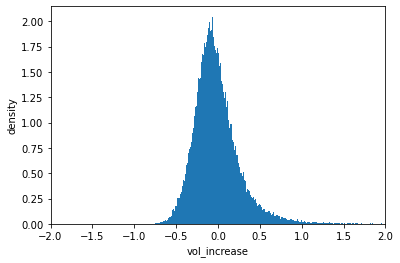

In [4]:
def plot_hist(x, xlim, title, bins=2000):

    plt.hist(x, density=True, bins=bins)
    plt.ylabel('density')
    plt.xlabel(title)
    plt.xlim(*xlim)

plot_hist(targets.vol_increase, (-2,2), 'vol_increase')

In [5]:
# removemos los casos extremos que cambian radicalmente (poco representativos)
targets = targets[(targets.vol_increase > -0.5) & (targets.vol_increase < 0.5)]
#targets

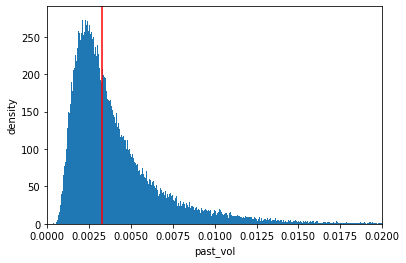

In [6]:
plot_hist(targets.past_vol, (0,0.02), 'past_vol')
plt.axvline(x=np.median(targets.past_vol),color='red')

In [7]:
# creamos dos grupos, uno representa tipicos casos de data points volátiles, otro no volátiles
volatile = targets[(targets.past_vol > 0.0030) & (targets.past_vol < 0.006)]
quite    = targets[(targets.past_vol > 0.0015) & (targets.past_vol < 0.003)]

len(volatile), len(quite)

(35121, 34709)

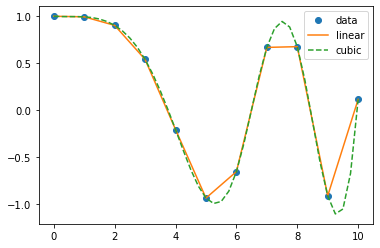

In [8]:
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

xnew = np.linspace(0, 10, num=41, endpoint=True)
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 84]


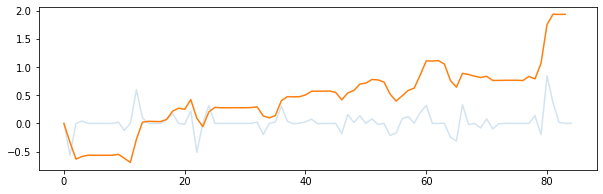

In [156]:
s=series[1,0]

x = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,84]
y = s[x]
xs = torch.linspace(0, 84, 84)
#xs[4]=np.nan

print(x)
fig, (ax) = plt.subplots(1,1,figsize=(10,3))
plt.plot(s, alpha=1.2)
#plt.plot(interp(torch.tensor(x), torch.tensor(y), xs))
plt.plot(integ(torch.tensor(np.arange(85)), torch.tensor(s), xs))

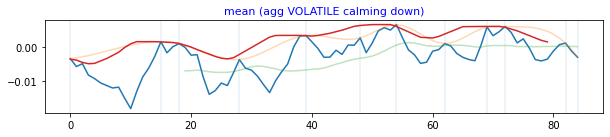

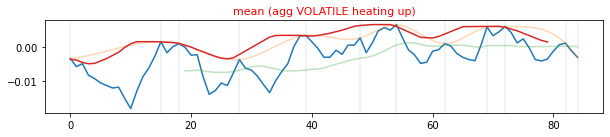

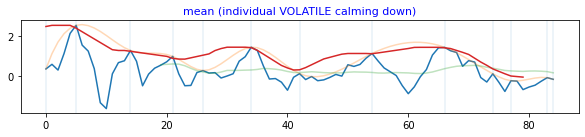

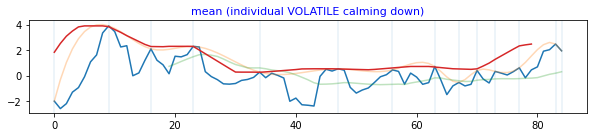

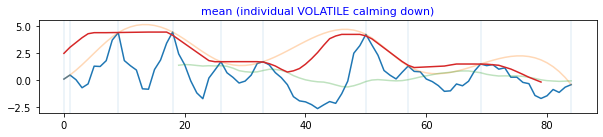

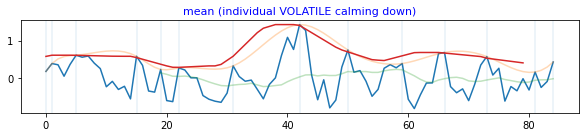

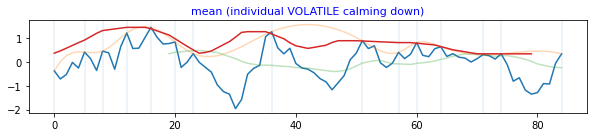

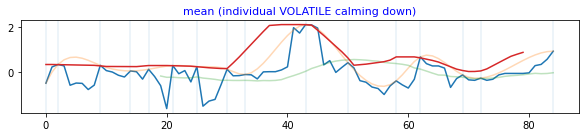

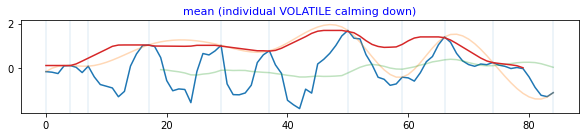

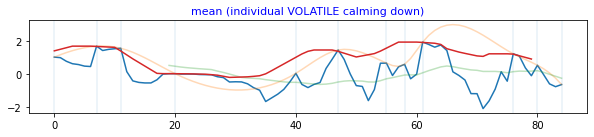

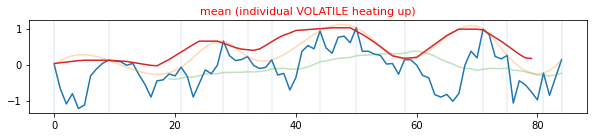

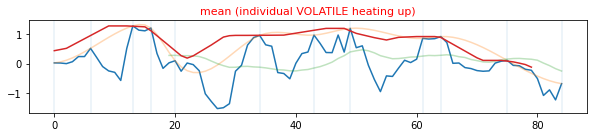

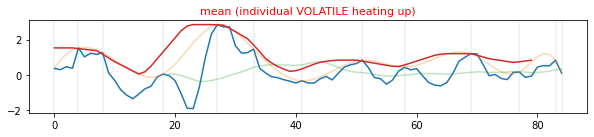

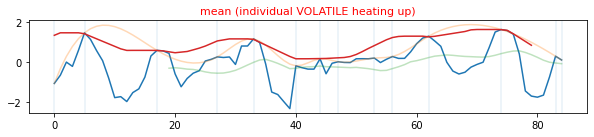

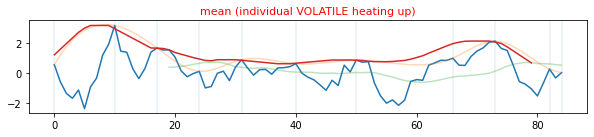

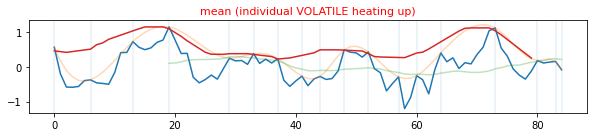

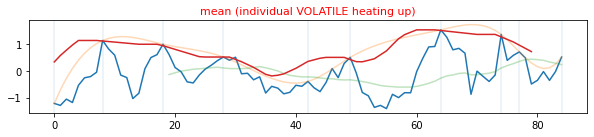

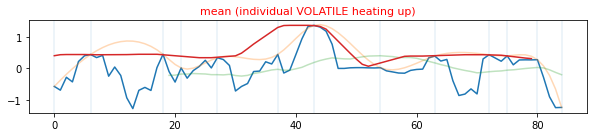

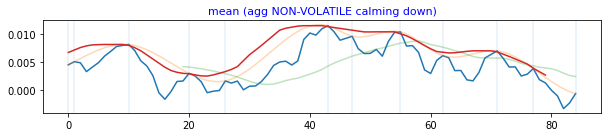

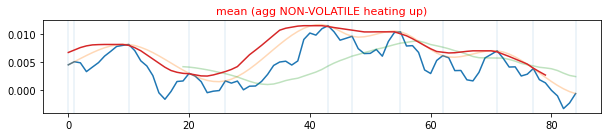

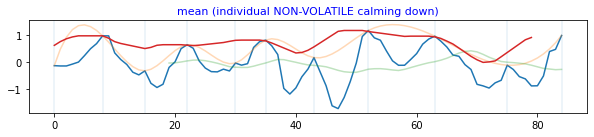

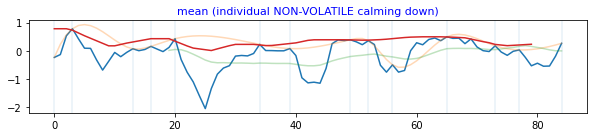

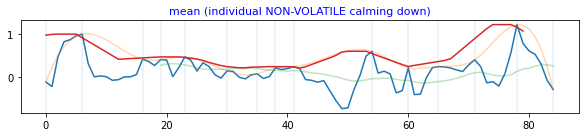

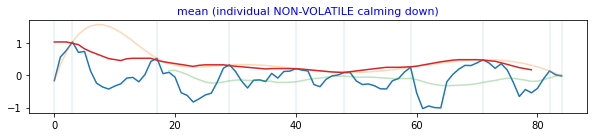

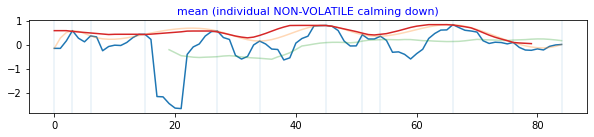

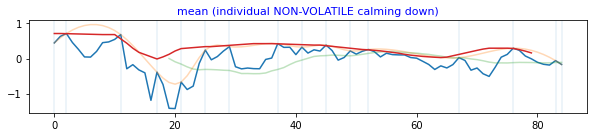

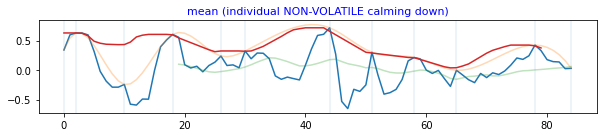

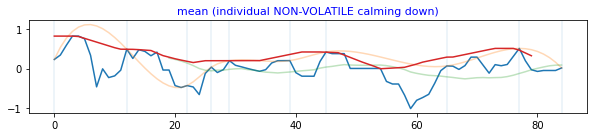

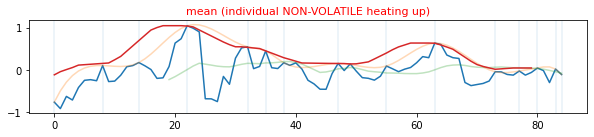

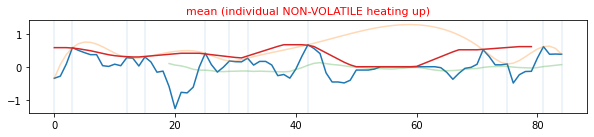

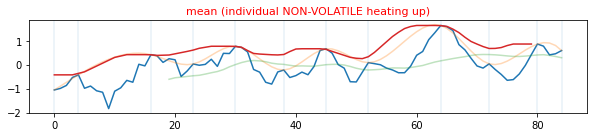

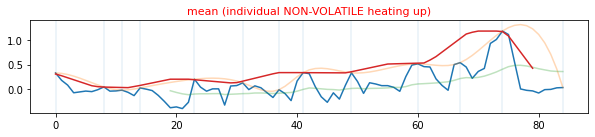

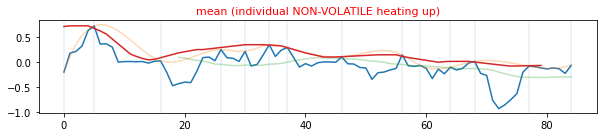

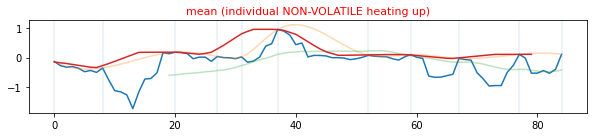

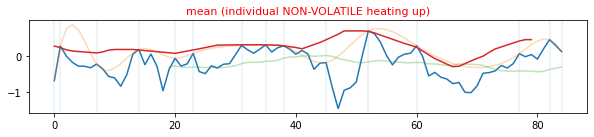

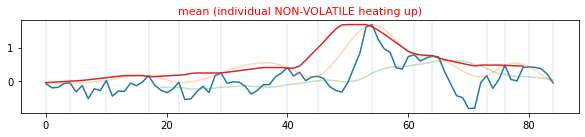

In [172]:
# Para ambos y grupos y para un tercer grupo contiendo todo, los subdividimos entre:
# incrementando volatilidad y disminuyendo volatilidad, y analizamos las series en agregado

def getvarname(i):
    if i==0: return 'raw'
    if i==1: return 'mean'
    if i==2: return 'std'
    if i==3: return 'min-max spread'
    if i==4: return 'max'
    return str(i)

def show_agg_series(bunch, voltype, maxim=100000, num_ind=8):

    everything   = np.mean(series[bunch.series],axis=0)
    calming_down = np.mean(series[bunch.iloc[:maxim].series],axis=0)
    heating_up   = np.mean(series[bunch.iloc[-maxim:].series],axis=0)

    individual_calming_down = series[bunch.iloc[:num_ind].series]
    individual_heating_up = series[bunch.iloc[-num_ind:].series]

    def display(s, t, r):

        fig, (ax) = plt.subplots(1,1,figsize=(10,1.7))#1.7

        ax.set_title(t,fontsize=11, color = ('red' if r else 'blue'))
        ax.plot(s, alpha=1); #ax.set_ylim(l, h)

        #peaks, _ = find_peaks(s, prominence=0.1)
        #print('peaks',peaks); print('maxi',argrelmax(s,order=30)[0])
        peaks = argrelmax(s,order=2)[0]

        if not 0 in peaks:
            peaks = np.append(peaks, [0])

        if not (len(s)-1) in peaks:
            peaks = np.append(peaks, [len(s)-1])

        for p in peaks:
            ax.axvline(x=p, alpha=0.1)

        if len(peaks)>3:

            f = interp1d(peaks, s[peaks], kind='cubic')
            ax.plot(f(range(len(s))), alpha=0.3)

        rolling = pd.Series(s).rolling(20).mean()
        ax.plot(rolling, alpha=0.3)

        x = F.max_pool1d(torch.tensor(s).unsqueeze(0).unsqueeze(0), 10, 1, padding=5)
        x = F.avg_pool1d(x, kernel_size=7, stride=1).squeeze()
        ax.plot(x)

        plt.show()

    for i in range(everything.shape[0]):

        if not i in [1]:
            continue

        display(calming_down[i], getvarname(i) + ' (agg ' + voltype.upper() + ' calming down)', False)
        display(heating_up[i], getvarname(i) + ' (agg ' + voltype.upper() + ' heating up)', True)
        #display(everything[i], getvarname(i) + ' (agg ' + voltype + ' going up or down)', lol)
        print()

        for j in range(num_ind):
            display(individual_calming_down[j,i], getvarname(i) + ' (individual ' + voltype.upper() + ' calming down)', False)

        for j in range(num_ind):
            display(individual_heating_up[j,i], getvarname(i) + ' (individual ' + voltype.upper() + ' heating up)', True)

show_agg_series(volatile, 'volatile')
print(); print()
show_agg_series(quite, 'non-volatile')
print(); print()
#show_agg_series(targets, 'mix of volatile and quite')

In [ ]:
# wap_means = np.std(data.WAP, axis=1)

In [ ]:
# def plot_hist(x,bins=1000):

#     plt.hist(x, density=True, bins=bins)
#     plt.ylabel('Density')
#     plt.xlabel('Price')
#     #plt.xlim(0.98,1.02)
#     plt.xlim(0,0.01)

# plot_hist(wap_means)

In [ ]:
# def plot_hist(x,bins=1000):

#     plt.hist(x, density=True, bins=bins)
#     plt.ylabel('Density')
#     plt.xlabel('Realized Volatility')
#     plt.xlim(0,0.02)

# plot_hist(data.targets[:,2])

In [ ]:
# target_means = pd.DataFrame(data.targets).groupby(0).agg({2:'mean'})
# target_means = target_means.rename(columns={2: "mean"})

# targets_values = pd.DataFrame(data.targets).groupby(0)[2].apply(list)
# targets_values = targets_values.rename("values")

# targets = pd.concat((target_means, targets_values), axis=1)

# targets.sort_values('mean', ascending=True, inplace=True)

# #targets

In [ ]:
# plot_hist(targets.iloc[0,1], 200)
# plot_hist(targets.iloc[-1,1], 200)

The order book helps traders to make more informed trading decisions by showing order imbalances that may provide clues to a stock’s direction in the very short term. A huge imbalance of buy orders against sell orders may indicate a move higher in the stock due to buying pressure, or vice versa. Traders can also use the order book to help pinpoint a stock’s potential support and resistance levels. A cluster of large buy orders at a specific price may indicate a level of support, while an abundance of sell orders at or near one price may suggest an area of resistance. Realized volatilities increase when those moves in either directions become more frequent.https://www.kaggle.com/gunesevitan/optiver-realized-volatility-prediction-eda